# Comparing rainy weather across cities in the continental U.S.A.
##### Author: John Mays
## Setup:

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# the code from this notebook has been moved to this .py file:
import city_comparison_helpers as cch
import schema
import plot_utils

In [2]:
mpl.rcParams['figure.dpi'] = 150

The question here is, what cities should I consider?  The more cities I consider, the more data I'd have to download.  If I downloaded the **GSOY** CSV for every one of the 83,000 or so weather stations that are listed, I'd have to download ~16GB of CSVs (a rough and likely low estimate).  If I wanted to bring in some big data technologies, I could do it, but I don't. So, should I...
- get a list of cities commonly considered rainy and find one weather station per city?
- get one weather station for every "big" city in the U.S.
- get all of the weather stations in a few states?

Although it's not perfect, I will likely go with the first option

##### What cities did I land on?
- I looked for weather stations near both small towns and big cities commonly considered rainy.  So that means bigger cities like C

In [3]:
cities = pd.read_csv('../data/cities.csv')
cities.head()

,Unnamed: 0,City,State,Station,Size
0,0,Seattle,WA,USW00094290,City
1,1,Miami,FL,USW00012839,City
2,2,New York City,NY,USW00094728,City
3,3,Lake Placid,NY,USW00094740,Town
4,4,Brookhaven,NY,USW00054790,Town


In [4]:
schema.partial_GSOY_schema
# cch.partial_schema.loc["DYHF"]

,Description
Column,
DATE,year AD
LATITUDE,
LONGITUDE,
PRCP,total annual precipitation in inches
SNOW,total annual snowfall in inches
DYFG,number of days with fog
DYHF,number of days with 'heavy' fog
DYTS,number of days with thunderstorms
EMXP,highest daily total of precipitation in inches


In [5]:
# range of years I'm looking at:
rng = (2012, 2021) # (inclusive)

In [6]:
cch.check_years(cities, rng=rng)

There are no missing years in the data.


In [7]:
columns = list(schema.partial_GSOY_schema.index.to_series())

In [8]:
cities_weather = cch.total_concat(cities, columns, rng=rng)

## Looking at statistics:
### Adding a few columns:

In [9]:
cities_weather["SNPR"] = cities_weather["SNOW"].fillna(0.0) \
+ cities_weather["PRCP"]

### Finding mean and median over an 11 year time period (2012-2022)

In [10]:
grouped_median = cities_weather.groupby('CITY').median()
grouped_mean = cities_weather.groupby('CITY').mean()

### Looking at some ranked lists and numbers:

#### Two ways of measuring precipitation
1. Annual rainfall sum
2. number of days with (any amount of) rain per year

In [11]:
cch.series_comparison(grouped_median["PRCP"].sort_values(ascending=False),
                  grouped_median["DP01"].sort_values(ascending=False),
                  titles = ["Rainfal per year (mm)", "Number of days with any rainfall"])

Rainfal per year (mm)     | Number of days with any rainfall
CITY                      | CITY
Annette           3782.85 | Hilo              270.5
Paradise          3275.50 | Annette           237.0
Quinault          3166.45 | Forks             224.5
Forks             3103.75 | Raymond           220.0
Hilo              3007.15 | Quillayute        196.0
Quillayute        2733.55 | Astoria           194.0
Aberdeen          2336.75 | Aberdeen          193.0
Raymond           2326.75 | Hoquiam           182.5
Tillamook         2032.15 | Paradise          182.0
Brevard           1997.40 | Rochester         179.5
Pensacola         1932.65 | Lake Placid       177.0
Hoquiam           1893.95 | Syracuse          174.5
Astoria           1863.55 | Bellingham        173.5
Port Arthur       1776.00 | Erie              171.5
New Orleans       1766.00 | Ithaca            169.5
Baton Rougs       1723.40 | Seattle           168.5
Lafayette         1709.15 | Buffalo           166.0
Gautier           1694

#### Two ways of measuring snow
1. Annual snowfall sum
2. number of days with (any amount of) snow per year

In [12]:
cch.series_comparison(grouped_median["SNOW"].sort_values(ascending=False),
                  grouped_median["DSNW"].sort_values(ascending=False),
                  titles = ["Snowfall per year (mm)", "Number of days with any snowfall"])

Snowfall per year (mm)   | Number of days with any snowfall
CITY                     | CITY
Presque Isle      3275.0 | Driggs            41.5
Driggs            3074.0 | Syracuse          31.5
Syracuse          2788.0 | Presque Isle      31.0
Brassau Dam       2540.5 | Brassau Dam       27.5
Rochester         2266.0 | Rochester         23.5
Erie              2264.0 | Buffalo           23.5
Buffalo           2050.0 | Erie              23.0
Ithaca            1295.0 | Ithaca            17.0
Boston            1160.5 | Cleveland         16.0
Cleveland         1158.5 | Spokane           14.0
Chicago           1099.0 | Madison           14.0
Spokane           1000.5 | Chicago           13.0
Detroit            975.0 | Detroit           11.5
Madison            956.0 | Boston            10.5
Norton             845.0 | Norton            10.0
New York City      817.0 | Columbus           9.5
Columbus           669.5 | West Lafayette     7.0
Philadelphia       539.5 | Wenatchee          7.0
Wenatche

#### Total mm of Precipitation (snow & everything else):

In [13]:
# grouped_median["SNPR"] = grouped_median["SNOW"].fillna(0.0) \
# + grouped_median["PRCP"]
# grouped_mean["SNPR"] = grouped_mean["SNOW"].fillna(0.0) \
# + grouped_mean["PRCP"]
grouped_median["SNPR"].sort_values(ascending=False)

CITY
Presque Isle    4444.65
Syracuse        3962.00
Annette         3782.85
Driggs          3769.45
Brassau Dam     3527.30
                 ...   
Sequim           463.70
Mount Carmel     443.90
Monterey         396.85
Bend             187.75
Richland         170.25
Name: SNPR, Length: 89, dtype: float64

#### Fog compared to Rain (median of `DYFG` & `DPO1`)

In [14]:
cch.series_comparison(grouped_median["DYFG"].sort_values(ascending=False),
                  grouped_median["DP01"].sort_values(ascending=False),
                  titles = ["Median number of foggy days", "Median number of rainy days"])

Median number of foggy days | Median number of rainy days
CITY                        | CITY
Hoquiam           285.0     | Hilo              270.5
Lake Placid       279.5     | Annette           237.0
Quillayute        267.5     | Forks             224.5
Olympia           252.5     | Raymond           220.0
Astoria           239.5     | Quillayute        196.0
Augusta           239.0     | Astoria           194.0
Lake Jackson      232.5     | Aberdeen          193.0
Cresecent City    230.0     | Hoquiam           182.5
Hilo              222.5     | Paradise          182.0
Port Arthur       215.0     | Rochester         179.5
Glen Falls        207.5     | Lake Placid       177.0
Annette           202.5     | Syracuse          174.5
Eugene            199.5     | Bellingham        173.5
Baton Rougs       195.0     | Erie              171.5
Tallahasse        191.0     | Ithaca            169.5
Lafayette         188.5     | Seattle           168.5
Columbia          185.0     | Buffalo      

#### Days with thunderstorms:

In [15]:
grouped_mean["DYTS"].sort_values(ascending=False)

CITY
West Palm      91.3
Orlando        89.4
Tallahasse     82.6
New Orleans    81.9
Miami          80.4
               ... 
Sequim          NaN
Tacoma          NaN
Tillamook       NaN
Wenatchee       NaN
Woods Hole      NaN
Name: DYTS, Length: 89, dtype: float64

- Apparently in the South, when it rains, it storms. Not so much in the North.
- The underlying relationship, it seems, is that the cities with the most thunderstorms are closest to the Gulf of Mexico
- On the other side of that, cities on the West Coast have very few.

## Plotting the Cities:

In [16]:
usa = gpd.read_file("../data/map/US_State_Boundaries.geojson")

# range for U.S. w/o Alaska: 
longitude_range = (-127, -66)
latitude_range = (23.5, 50)

degrees_per_inch = 2.5

width = ((longitude_range[1] - longitude_range[0]) / degrees_per_inch) + 2
# the (+ 2 is to accomodate for the colorbar)
height = (latitude_range[1] - latitude_range[0]) / degrees_per_inch

In [17]:
grouped_median["SIZE"] = 800 * ((grouped_median["DP01"]-(0.5*grouped_median["DP01"].min()))/grouped_median["DP01"].max())

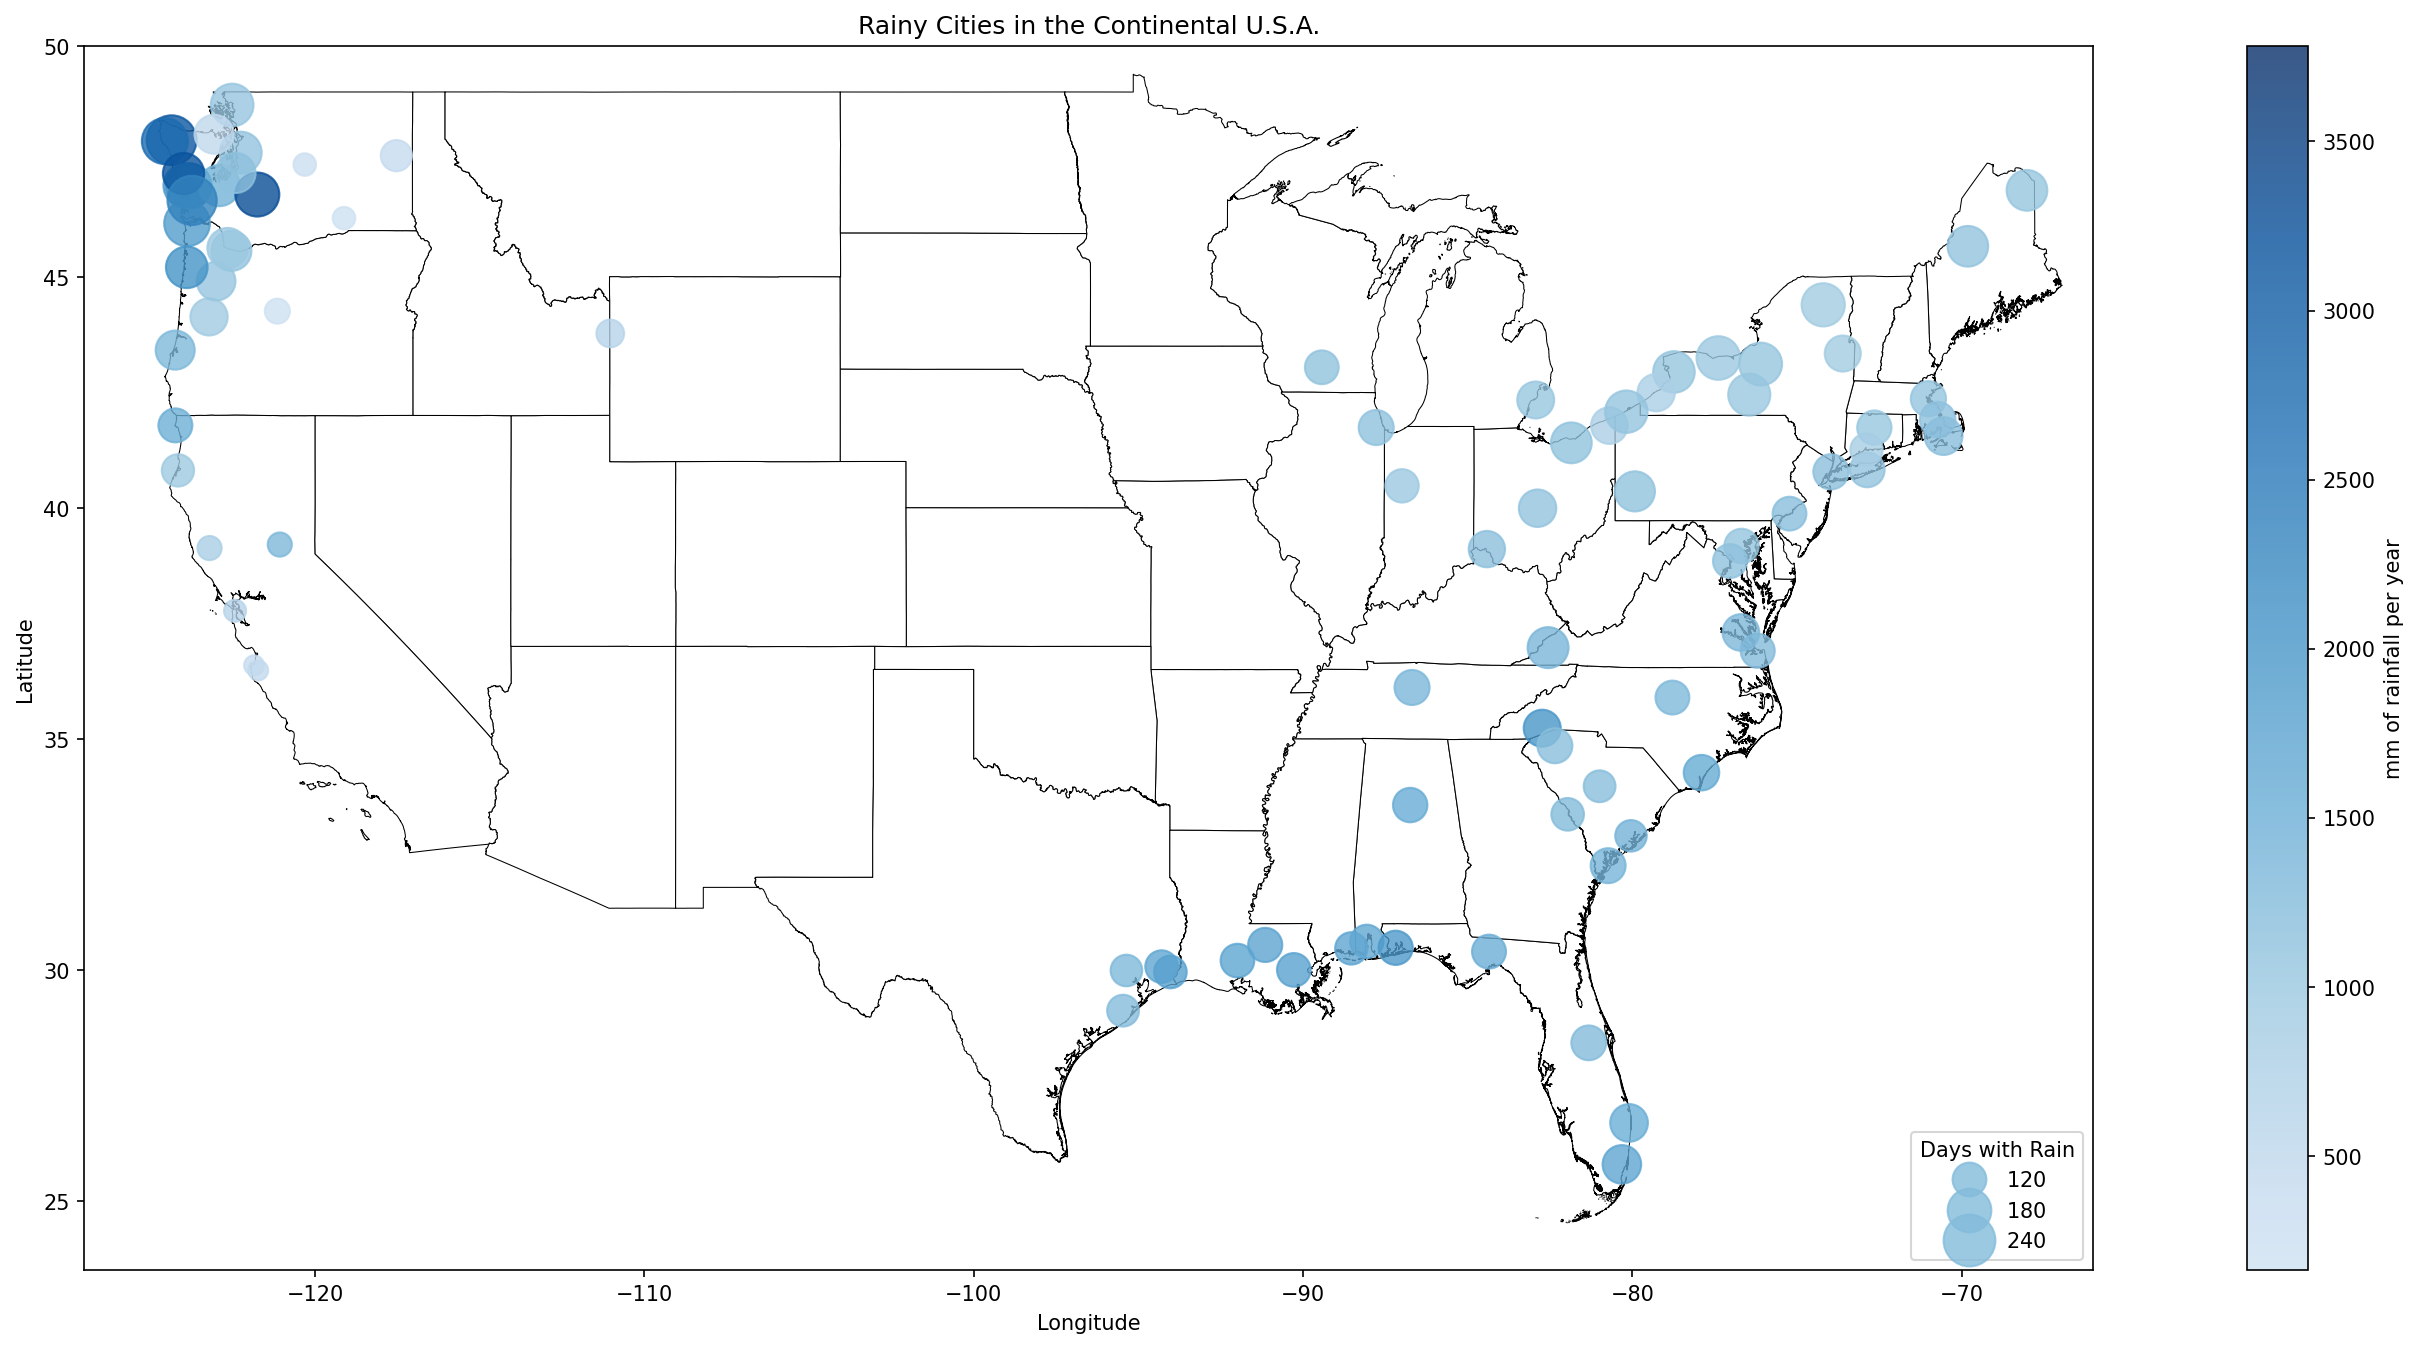

In [18]:
usa.plot(color="white", edgecolor="black", linewidth=0.5,
         figsize=(width, height))
scatter = plt.scatter(grouped_median["LONGITUDE"], grouped_median["LATITUDE"],
            alpha = 0.8, s = grouped_median["SIZE"],
            c=grouped_median["PRCP"], cmap=plot_utils.Blues_subsection)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim(longitude_range)
plt.ylim(latitude_range)
plt.title("Rainy Cities in the Continental U.S.A.")
plt.colorbar(label="mm of rainfall per year")
plt.legend(*scatter.legend_elements(prop='sizes', num=4, 
           func=(lambda x: ((x/800)*grouped_median["DP01"].max())
           + (0.5*grouped_median["DP01"].min())), color=scatter.cmap(0.3)),
           loc="lower right", title='Days with Rain')
plt.show()

In [19]:
town_schema_WA = cities[(cities['State'] == 'WA')]
town_schema_WA

,Unnamed: 0,City,State,Station,Size
0,0,Seattle,WA,USW00094290,City
14,14,Forks,WA,USC00452914,Town
19,19,Richland,WA,USW00024163,Town
29,29,Sequim,WA,USC00457544,Town
30,30,Spokane,WA,USW00024157,City
31,31,Quillayute,WA,USW00094240,Town
32,32,Aberdeen,WA,USC00450008,Town
33,33,Hoquiam,WA,USW00094225,Town
42,42,Tacoma,WA,USC00458278,City
43,43,Vancouver,WA,USW00094298,City


In [20]:
cities_WA = cch.total_concat(town_schema_WA, columns, rng=rng)

In [21]:
grouped_median_WA = cities_WA.groupby('CITY').median()

In [22]:
grouped_median_WA.index.to_series()

CITY
Aberdeen        Aberdeen
Bellingham    Bellingham
Forks              Forks
Hoquiam          Hoquiam
Olympia          Olympia
Paradise        Paradise
Quillayute    Quillayute
Quinault        Quinault
Raymond          Raymond
Richland        Richland
Seattle          Seattle
Sequim            Sequim
Spokane          Spokane
Tacoma            Tacoma
Vancouver      Vancouver
Wenatchee      Wenatchee
Name: CITY, dtype: object

_(at this point I am realizing, if I was smarter, I would have just put everything into one dataframe/CSV)_

In [23]:
wa = usa[(usa['STATE_ABBR'] == 'WA')]

# range for U.S. w/o Alaska: 
longitude_range = (-125.5, -116)
latitude_range = (45, 49.5)

degrees_per_inch = 0.5

width = ((longitude_range[1] - longitude_range[0]) / degrees_per_inch) + 2
# the (+ 2 is to accomodate for the colorbar)
height = (latitude_range[1] - latitude_range[0]) / degrees_per_inch

In [24]:
grouped_median_WA["SIZE"] = 800 * ((grouped_median_WA["DP01"]-(0.5*grouped_median_WA["DP01"].min()))/grouped_median_WA["DP01"].max())

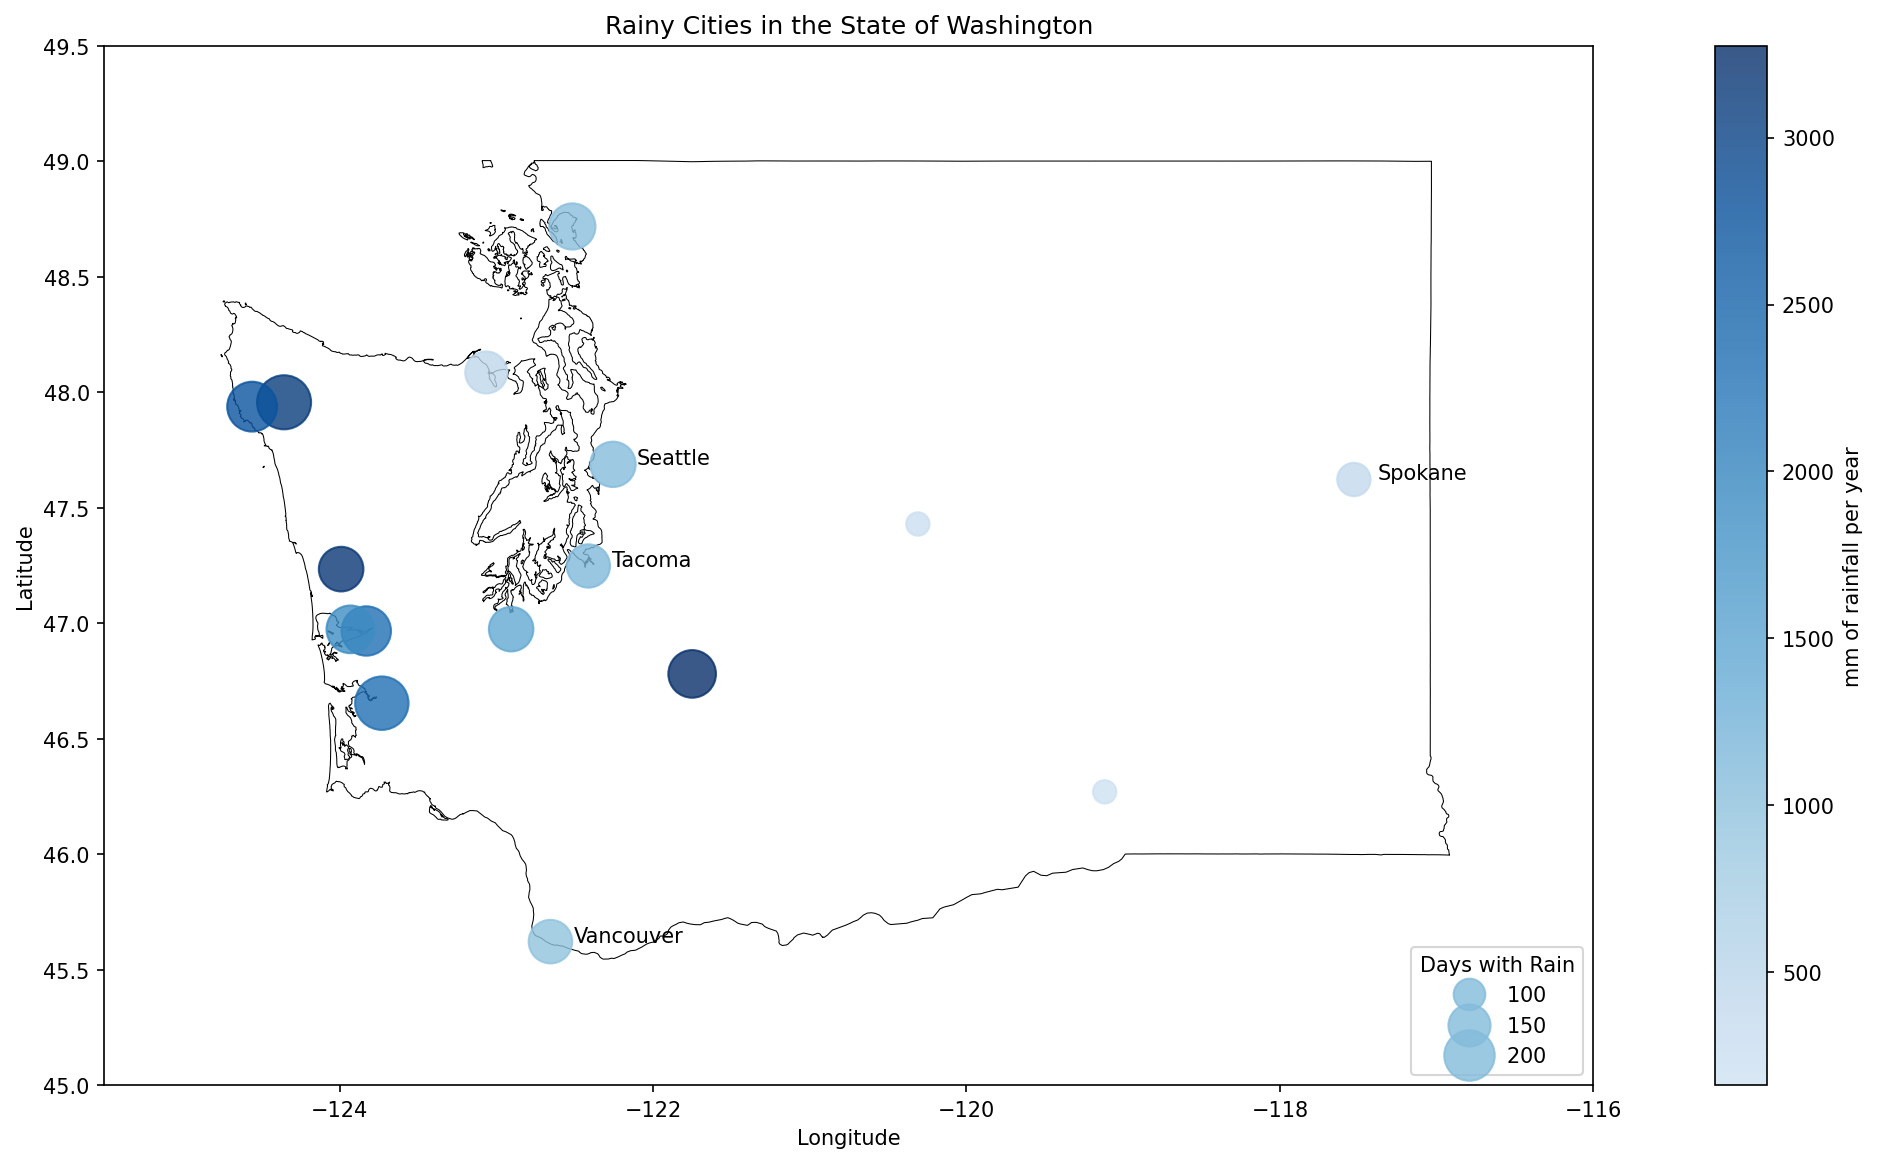

In [25]:
wa.plot(color="white", edgecolor="black", linewidth=0.5,
        figsize=(width, height))
scatter = plt.scatter(grouped_median_WA["LONGITUDE"], grouped_median_WA["LATITUDE"],
            alpha = 0.8, s = grouped_median_WA["SIZE"],
            c=grouped_median_WA["PRCP"], cmap=plot_utils.Blues_subsection)
for city, row in grouped_median_WA.iterrows():
    if (cities[cities['City']==city]['Size']=='City').any():
        plt.text(x=row["LONGITUDE"]+0.15, y=row["LATITUDE"],s=city)      
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim(longitude_range)
plt.ylim(latitude_range)
plt.title("Rainy Cities in the State of Washington")
plt.colorbar(label="mm of rainfall per year")
plt.legend(*scatter.legend_elements(prop='sizes', num=4, 
           func=(lambda x: ((x/800)*grouped_median_WA["DP01"].max())
           + (0.5*grouped_median_WA["DP01"].min())), color=scatter.cmap(0.3)),
           loc="lower right", title='Days with Rain')
plt.show()

## Issues
### Statistical Issues:
- **Weather station may not be representative of entire city:** Especially with measurements like days with fog, which is a spotty phenomenon, you could be living somewhere around a city, but just not close enough to the weather station to see what they report.  For example, in Cleveland, if you live a few miles from Lake Erie, you will be much less likely to see fog than the weather station close to Lake Erie.  
- Also, in an ideal world, I would attempt to take measurements from several weather stations and aggregate them somehow to be more representative of a general area.  Although, since there are quite a few small towns with relatively sparse data available, I'm not so sure that would be smart.
- **Sample size:** I am only sampling 2012-2021 here, 10 years.  I wish I could sample back into the 70's or so, but there are too many fragmented datasets to pick a larger range, so 11 years of data will have to do.  If I am curious about comparing a few cities furthere, I may use Global Summary of the Month (**GSOM**) data to look further.
- **You may be tempted to say a city on here is "high" or "low" compared to others,** however, this dataset was hand-selected and is skewed towards notoriously rainy places, so it wouldn't really be honest to say "Lafayette gets low rain" because it is only being compared to the upper echelon of rainy places in the USA.